## Import some library

In [86]:
import os
import time
from tqdm.notebook import tqdm
from pprint import pprint
import recmetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from surprise import NMF as nmf
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as split

from utils import train_test_split
from model_selection import SVD, fastSVD, NMF, DeepMF , NeuralMF

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
sns.set(rc={'figure.figsize':(10, 6)})
seed = 123
np.random.seed(seed)

## 1. Load data

### Summary

```
ml-1m
├── users.dat
├── movies.dat
├── ratings.dat
└── README.txt
```

In [4]:
PATH = "ml-1m/"
ratings = pd.read_csv(os.path.join(PATH, 'ratings.dat'), sep='::', names=["userID", "movieID", "rating", "timestamp"], engine='python')
movies = pd.read_csv(os.path.join(PATH, 'movies.dat'), sep='::', names=["movieID", "title", "genres"], engine='python')
users = pd.read_csv(os.path.join(PATH, 'users.dat'), sep='::', names=["userID", "gender", "age", "occupation", "zipcode"], engine='python')

In [5]:
users

,userID,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


## 2. EDA

### 2.1 ratings.dat

In [6]:
ratings.head()

,userID,movieID,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


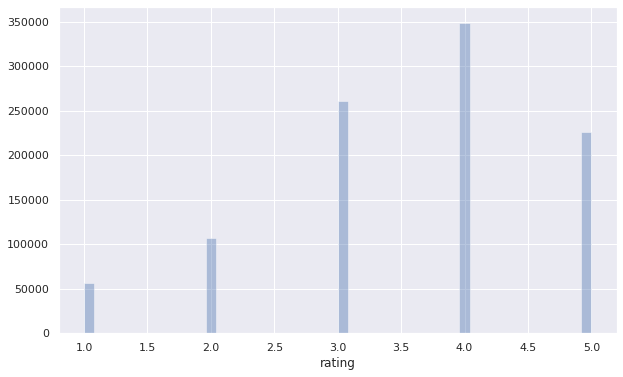

In [7]:
sns.distplot(ratings["rating"], kde=False)

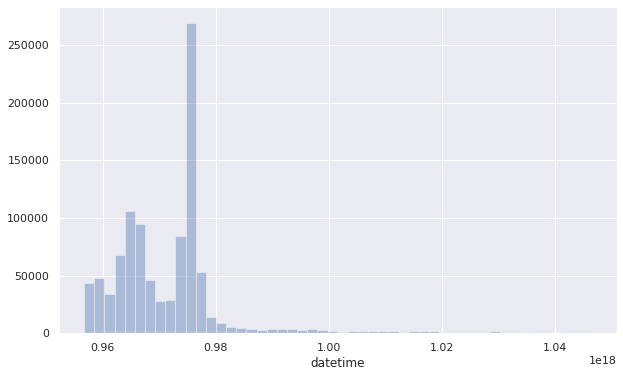

In [8]:
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.drop('timestamp', axis=1, inplace=True)
sns.distplot(ratings['datetime'], kde=False)

In [9]:
n_users = len(ratings.userID.unique())
n_items = len(ratings.movieID.unique())
print(n_users)
print(n_items)
print("Coverage : {:.4f}%".format(len(ratings) * 100 / (n_users * n_items)))

6040
3706
Coverage : 4.4684%


### 2.2 movies.dat

In [10]:
movies.head()

,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
movies_refine = movies.copy()
movies_refine['year'] = (movies_refine['title'].str.extract(r'(\d{4})')).astype('int32')
movies_refine = movies_refine.dropna()
movies_refine['title'] = (movies_refine['title'].str.extract(r'(^[^\(]+)'))[0]
movies_refine['genres'] = movies_refine['genres'].str.split('|')

movies_refine

,movieID,title,genres,year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000
3879,3949,Requiem for a Dream,[Drama],2000
3880,3950,Tigerland,[Drama],2000
3881,3951,Two Family House,[Drama],2000


In [12]:
movies_refine.year.unique()
movies_refine.year.value_counts()

1996    344
1995    342
1998    335
1997    314
1999    281
       ... 
2001      1
2010      1
3000      1
1921      1
8230      1
Name: year, Length: 88, dtype: int64

In [13]:
genre_count = dict()
for index, series in movies_refine.iterrows():
    for genre in series['genres']:
        genre_count[genre] = genre_count.get(genre, 0) + 1
pprint(genre_count)

{'Action': 503,
 'Adventure': 283,
 'Animation': 105,
 "Children's": 251,
 'Comedy': 1200,
 'Crime': 211,
 'Documentary': 127,
 'Drama': 1603,
 'Fantasy': 68,
 'Film-Noir': 44,
 'Horror': 343,
 'Musical': 114,
 'Mystery': 106,
 'Romance': 471,
 'Sci-Fi': 276,
 'Thriller': 492,
 'War': 143,
 'Western': 68}


### 2.3 users.dat

In [14]:
users.head()

,userID,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [15]:
users.gender.value_counts()

M    4331
F    1709
Name: gender, dtype: int64

In [16]:
users.age.value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [17]:
len(users)

6040

In [18]:
len(ratings.userID.unique())

6040

## 3. Matrix Factorization Collaborative Filtering

In [15]:
X_train, X_valid, X_test = train_test_split(ratings[["userID", "movieID", "rating"]], split_ratio=0.8, shuffle=True, output_type='df')

In [6]:
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(ratings[['userID', 'movieID', 'rating']], reader=reader)
trainset, testset = split(dataset, test_size=0.1)
testset = pd.DataFrame(testset, columns=['userID', 'movieID', 'rating']).astype(int)
test_benchmark = testset.copy()

user_idx = ratings['userID'].unique().tolist()
item_idx = ratings['movieID'].unique().tolist()
user_dict = dict(zip(user_idx, [i for i in range(len(user_idx))]))
item_dict = dict(zip(item_idx, [i for i in range(len(item_idx))]))

### 3.1 Low rank Approximation (Truncated SVD)

In [7]:
# Create matrix
data_mat = np.array(ratings.pivot(index = 'movieID', columns = 'userID', values = 'rating'))
data_mat = np.nan_to_num(data_mat)
# Normalize
nor_data_mat = data_mat - np.mean(data_mat, axis = 0)
# Truncated SVD (50 eigenvalues)
u, s, vT = svds(nor_data_mat, k = 50)
# Reconstruct matrix using Truncated SVD
recon_data_mat = u.dot(np.diag(s)).dot(vT)

In [8]:
pred = []
for ui, ii in zip(testset.userID, testset.movieID):
    pred = recon_data_mat[item_dict[ii], user_dict[ui]]
print("RMSE loss (truncatedSVD) testset: {:.4f}".format(np.sqrt(np.mean(X_test.rating - pred)**2)))

RMSE loss (truncatedSVD) testset: 3.4342


In [9]:
def recommend_movies(pred_matrix, userID, num_recommendations):
    """Recommend movies based on reconstructed svd matrix
    Params:
     - pred_matrix (num_movies, num_users) : reconstructed matrix
     - userID (scalar)
     - num_recommendations (scalar)
    Outputs:
     - movies
    """
    sorted_predict_idx = np.argsort(pred_matrix[:, userID-1])[::-1]

    user_data = ratings[ratings.userID == (userID)]
    user_full = user_data.merge(movies).sort_values(['rating'], ascending=False)
    print('User {0} has already rated {1} movies.'.format(userID, len(user_full)))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))

    recommendations = movies.loc[sorted_predict_idx, :]
    recommendations['pred_rating'] = pred_matrix[sorted_predict_idx, userID-1]
    recommendations = recommendations[~movies.movieID.isin(user_full.movieID)].head(num_recommendations)

    return recommendations

In [10]:
recon = recommend_movies(recon_data_mat, 96, 20)
recon

User 96 has already rated 81 movies.
Recommending highest 20 predicted ratings movies not already rated.


,movieID,title,genres,pred_rating
309,312,Stuart Saves His Family (1995),Comedy,5.364311
513,517,Rising Sun (1993),Action|Drama|Mystery,5.298545
1848,1917,Armageddon (1998),Action|Adventure|Sci-Fi|Thriller,5.033802
579,583,Dear Diary (Caro Diario) (1994),Comedy|Drama,4.331755
106,108,Catwalk (1995),Documentary,4.236774
593,597,Pretty Woman (1990),Comedy|Romance,3.402118
1107,1123,"Perfect Candidate, A (1996)",Documentary,3.342127
2557,2626,Edge of Seventeen (1998),Comedy|Drama|Romance,3.278566
1106,1122,Plutonium Circus (1995),Documentary,3.229110
2203,2272,One True Thing (1998),Drama,3.139722


### 3.2.1 FunkSVD (slow ver.)

**Load model**

In [11]:
slow_svd = SVD(X_train, X_valid, K=15, lambd=0.1, lr_rate=2, max_iter=50, verbose=True, user_based=0, use_biased=True)

**Training phase and evaluate**

In [12]:
start = time.time()
slow_svd.fit()
print("It takes {}s to finish training phase".format(time.time() - start))
#
test_matrix = testset.values
test_matrix[:, :2] -= 1
print("RMSE loss with test set :",slow_svd.evaluate(test_matrix))

iter = 10 , loss = 3.666668593918189 , RMSE train = 0.992403691194758
iter = 20 , loss = 0.4316555253325737 , RMSE train = 0.9801125084039296
iter = 30 , loss = 0.12079419680707637 , RMSE train = 0.9799757647229623
iter = 40 , loss = 0.09041497620158898 , RMSE train before = 0.9799757647229623 ,RMSE train after = 0.9799729928199263
Stop
It takes 641.175267457962s to finish training phase
RMSE loss with test set : 0.9754092999709763


In [16]:
pred = [] 
for ui, ii in zip(testset.userID, testset.movieID):
    pred.append(slow_svd.predict(ui-1, ii-1))
test_benchmark['slow_svd'] = pred

In [97]:
def recommend_movies(model, userID, num_recommendations):
    rrs = []
    pred = model.predict_for_user(userID - 1)
    for k, v in sorted(pred.items(), key=lambda item: item[1])[::-1][:num_recommendations]:
        rrs.append(movies.loc[movies.movieID == k])
    
    recommendation = pd.concat(rrs)

    return pd.concat(rrs)

In [18]:
recommend_movies(slow_svd, 96, 20)

,movieID,title,genres
2633,2702,Summer of Sam (1999),Drama
232,235,Ed Wood (1994),Comedy|Drama
2583,2652,"Curse of Frankenstein, The (1957)",Horror
3815,3885,Love & Sex (2000),Comedy|Romance
3192,3261,Singles (1992),Comedy|Drama|Romance
860,871,Lover's Knot (1996),Comedy
1129,1145,Snowriders (1996),Documentary
1752,1817,No Looking Back (1998),Comedy|Drama|Romance
2551,2620,This Is My Father (1998),Drama|Romance
2347,2416,Back to School (1986),Comedy


### 3.2.2 FunkSVD (fast ver.)

**Load model & Training**

In [19]:
fast_svd = fastSVD(K=15, lambd=0.06, lr_rate=0.004, max_iter=50)
start = time.time()
fast_svd.fit(X_train, X_valid, early_stopping=False, verbose=True, use_biased=True)
print("It takes {}s to finish training phase".format(time.time() - start))

Load data & Preprocessing !
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Valid loss: 0.82653 --- Valid RMSE: 0.90914 --- Valid MAE: 0.72135
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Valid loss: 0.80227 --- Valid RMSE: 0.89569 --- Valid MAE: 0.70959
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Valid loss: 0.77158 --- Valid RMSE: 0.87840 --- Valid MAE: 0.69472
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Valid loss: 0.75099 --- Valid RMSE: 0.86660 --- Valid MAE: 0.68459
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Valid loss: 0.73842 --- Valid RMSE: 0.85932 --- Valid MAE: 0.67816
It takes 1.8370842933654785s to finish trainin

**Evaluate**

In [20]:
print("RMSE loss for testset ", fast_svd.evaluate(X_test))

RMSE loss for testset  0.8559064619608517


In [105]:
def recommend_movies(model, userID, num_recommendations):
    """
    """
    rrs = []
    pred = model.predict_for_user(userID)
    for k, v in sorted(pred.items(), key=lambda item: item[1])[::-1][:num_recommendations]:
        rrs.append(movies.loc[movies.movieID == k])
    
    recommendation = pd.concat(rrs)

    return pd.concat(rrs)

In [23]:
recommend_movies(fast_svd, 96, 20)

,movieID,title,genres
2836,2905,Sanjuro (1962),Action|Adventure
523,527,Schindler's List (1993),Drama|War
315,318,"Shawshank Redemption, The (1994)",Drama
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure
1132,1148,"Wrong Trousers, The (1993)",Animation|Comedy
941,953,It's a Wonderful Life (1946),Drama
1189,1207,To Kill a Mockingbird (1962),Drama
2434,2503,"Apple, The (Sib) (1998)",Drama
2255,2324,Life Is Beautiful (La Vita � bella) (1997),Comedy|Drama
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi


### 3.3 Nonnegative Matrix Factorization

**Load model**

In [102]:
model_nmf = NMF(K=15, lambd_pu=0.06, lambd_qi=0.06, max_iter=50)

**Training phase** (! Be aware of tuning hyperparams)

In [103]:
model_nmf.fit(X_train, X_valid, early_stopping=False, verbose=True)

Load data & Preprocessing !
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Valid loss: 25163485.145797864 --- Valid RMSE: 5016.321874221974 --- Valid MAE: 89.72486653624607
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Valid loss: 442916.85936810594 --- Valid RMSE: 665.5199917118238 --- Valid MAE: 10.265350753750232
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Valid loss: 467.1641880653231 --- Valid RMSE: 21.613981309914262 --- Valid MAE: 4.49896776443101
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Valid loss: 15903.132989035932 --- Valid RMSE: 126.10762462688737 --- Valid MAE: 4.678916825994688
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Valid loss: 2963.733382526901 --- Valid RMSE: 54.440181690796194 --- Valid MAE: 5.027876032404536
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Valid loss: 769867.7660307259 --- Valid RMSE: 877.4210882072108 --- Valid MAE: 9.924605362976973
Epoch 31/50
Epoch 32/50
Epoch 33/

In [ ]:
model_nmf = nmf()
model_nmf.fit(trainset)

In [179]:
predictions = model_nmf.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9118


0.9117739164591644

In [180]:
def recommend_movies(model, userID, num_recommendations):
    pred = {}
    rrs = []
    for iid in ratings.movieID.unique():
        pred[iid] = model.predict(str(userID), str(iid)).est

    for k, v in sorted(pred.items(), key=lambda item: item[1])[::-1][:num_recommendations]:
        rrs.append(movies.loc[movies.movieID == k])
    
    recommendation = pd.concat(rrs)

    return pd.concat(rrs)

In [181]:
recommend_movies(model_nmf, 96, 20)

,movieID,title,genres
2840,2909,"Five Wives, Three Secretaries and Me (1998)",Documentary
3538,3607,One Little Indian (1973),Comedy|Drama|Western
2776,2845,White Boys (1999),Drama
2634,2703,Broken Vessels (1998),Drama
2129,2198,Modulations (1998),Documentary
3461,3530,Smoking/No Smoking (1993),Comedy
283,286,Nemesis 2: Nebula (1995),Action|Sci-Fi|Thriller
1774,1843,Slappy and the Stinkers (1998),Children's|Comedy
3313,3382,Song of Freedom (1936),Drama
125,127,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama


## 4 Deep learning

### 4.1 Simple deep model using Embedding layer

**Prepare data for DeepMF model**

In [73]:
user_list = ratings['userID'].values.reshape(-1, 1) -1
item_list = ratings['movieID'].values.reshape(-1, 1) -1
rating_list = ratings['rating'].values.reshape(-1, 1)
max_user_id = ratings.userID.unique().max()
max_item_id = ratings.movieID.unique().max()

**Create and compile model**

In [74]:
model_deepmf = DeepMF(max_user_id, max_item_id, K=100)
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('deepmf_weights.h5', save_best_only=True)]
model_deepmf.compile(loss='mse', optimizer='adam')

In [75]:
history = model_deepmf.fit([user_list, item_list], rating_list, epochs=30,
                           validation_split=.3, verbose=1, callbacks=callbacks)

Train on 700146 samples, validate on 300063 samples
Epoch 1/30
700146/700146 [==============================] - 225s 322us/sample - loss: 2.2942 - val_loss: 14.2798
Epoch 2/30
700146/700146 [==============================] - 225s 322us/sample - loss: 0.8050 - val_loss: 14.2790
Epoch 3/30
700146/700146 [==============================] - 227s 325us/sample - loss: 0.6636 - val_loss: 14.2792
Epoch 4/30
700146/700146 [==============================] - 227s 324us/sample - loss: 0.5380 - val_loss: 14.2796


**Load trained model for prediction phase**

In [9]:
model_deepmf.load_weights('deepmf_weights.h5')

**Pred rating for testset**

In [ ]:
test_userid = testset.userID.tolist()
test_movieid = testset.movieID.tolist()
pred = [model_deepmf.predict_given_id(ui, ii) for ui, ii in tqdm(zip(test_userid, test_movieid))]

In [41]:
print("RMSE loss (deepMF) testset: ", np.sqrt(np.mean((X_test_deepmf.pred - X_test_deepmf.rating)**2)))

RMSE loss (deepMF) testset:  0.8486644449610745


**Recommend top 20 given userID**

In [119]:
def recommend_movies(model, userID, num_recommendations):
    pred = {}
    rrs = []
    for iid in ratings.movieID.unique():
        pred[iid] = model_deepmf.predict_given_id(userID, iid)

    for k, v in sorted(pred.items(), key=lambda item: item[1])[::-1][:num_recommendations]:
        rrs.append(movies.loc[movies.movieID == k])
    
    recommendation = pd.concat(rrs)
    return recommendation

In [120]:
recommend_movies(model_deepmf, 96, 20)

,movieID,title,genres
941,953,It's a Wonderful Life (1946),Drama
1022,1035,"Sound of Music, The (1965)",Musical
523,527,Schindler's List (1993),Drama|War
453,457,"Fugitive, The (1993)",Action|Thriller
1242,1262,"Great Escape, The (1963)",Adventure|War
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1267,1287,Ben-Hur (1959),Action|Adventure|Drama
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
902,914,My Fair Lady (1964),Musical|Romance
1230,1250,"Bridge on the River Kwai, The (1957)",Drama|War


### 4.2 Neural Collaborative Filtering

In [41]:
model_neuralmf = NeuralMF(max_item_id, max_user_id, latent_dim=64)

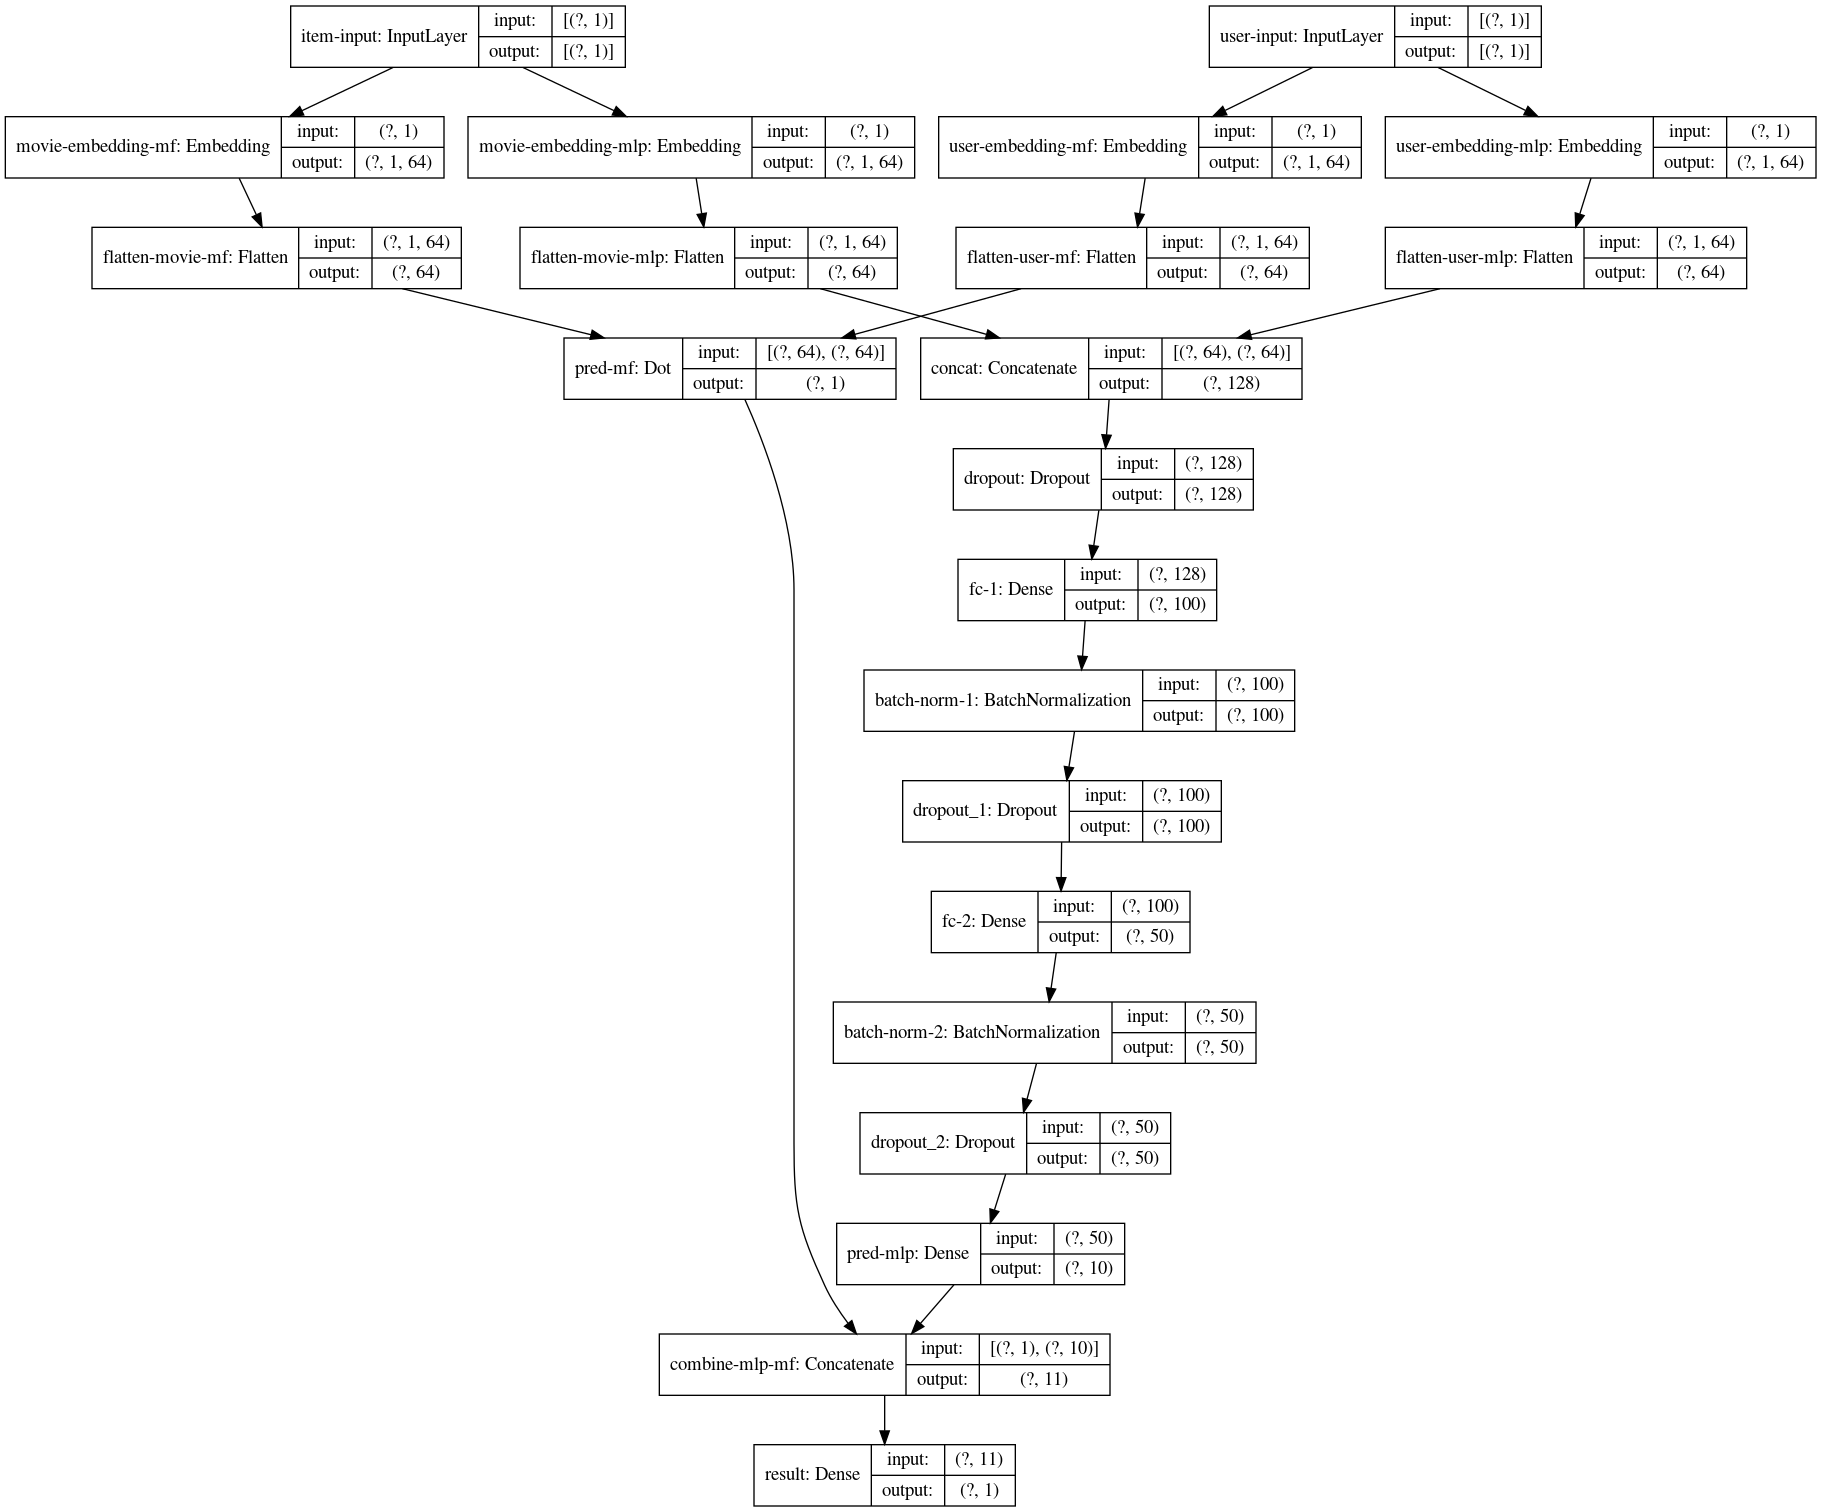

In [43]:
plot_model(model_neuralmf, show_shapes=True)

In [44]:
model_neuralmf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding-mlp (Embedding) (None, 1, 64)        252992      item-input[0][0]                 
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 64)        386624      user-input[0][0]                 
______________________________________________________________________________________________

In [47]:
model_neuralmf.compile(optimizer=optimizers.Adam(lr=0.01),
                       loss='mean_absolute_error')
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('neuralmf_weights.h5', save_best_only=True)]

In [48]:
history_neuralmf = model_neuralmf.fit([X_train.userID, X_train.movieID], X_train.rating, epochs=10,
                                       validation_split=.1, verbose=1, callbacks=callbacks)

Train on 720150 samples, validate on 80017 samples
Epoch 1/10
720150/720150 [==============================] - 358s 497us/sample - loss: 0.7704 - val_loss: 0.7194
Epoch 2/10
720150/720150 [==============================] - 307s 426us/sample - loss: 0.7201 - val_loss: 0.7278
Epoch 3/10
720150/720150 [==============================] - 307s 426us/sample - loss: 0.7056 - val_loss: 0.7002
Epoch 4/10
720150/720150 [==============================] - 307s 426us/sample - loss: 0.6987 - val_loss: 0.6909
Epoch 5/10
720150/720150 [==============================] - 307s 426us/sample - loss: 0.6942 - val_loss: 0.6958
Epoch 6/10
720150/720150 [==============================] - 307s 426us/sample - loss: 0.6916 - val_loss: 0.6894
Epoch 7/10
720150/720150 [==============================] - 307s 426us/sample - loss: 0.6890 - val_loss: 0.6901
Epoch 8/10
720150/720150 [==============================] - 307s 426us/sample - loss: 0.6863 - val_loss: 0.6853
Epoch 9/10
720150/720150 [===========================

In [62]:
pred = model_neuralmf.predict([X_test.userID, X_test.movieID])
print("RMSE loss (NeuralMF) testset: ",np.sqrt(mean_absolute_error(X_test.rating, pred)))

RMSE loss (NeuralMF) testset:  0.8407889743361613


In [170]:
def recommend_movies(model, userID, num_recommendations):
    pred = {}
    rrs = []
    for iid in ratings.movieID.unique():
        pred[iid] = model_neuralmf.predict([np.array([userID]), np.array([iid])])

    for k, v in sorted(pred.items(), key=lambda item: item[1])[::-1][:num_recommendations]:
        rrs.append(movies.loc[movies.movieID == k])
    
    recommendation = pd.concat(rrs)
    return recommendation

In [171]:
recommend_movies(model_neuralmf, 96, 20)

,movieID,title,genres
1162,1178,Paths of Glory (1957),Drama|War
3022,3091,Kagemusha (1980),Drama|War
2901,2970,Fitzcarraldo (1982),Adventure|Drama
1858,1927,All Quiet on the Western Front (1930),War
2719,2788,And Now for Something Completely Different (1971),Comedy
523,527,Schindler's List (1993),Drama|War
2241,2310,"Mighty, The (1998)",Drama
3265,3334,Key Largo (1948),Crime|Drama|Film-Noir|Thriller
2657,2726,"Killing, The (1956)",Crime|Film-Noir
2867,2936,Sullivan's Travels (1942),Comedy


## 5. Comparison

In [ ]:
xx = test_benchmark.copy().groupby('userID')['movieID'].agg(actual=(lambda x: list(set(x))))

### 5.1 RMSE

In [262]:
loss_all = {'Algorithms': ['TruncatedSVD', 'SlowSVD', 'FastSVD', 'NMF', 'DeepMF', 'NeuralMF'],
            'RMSE loss': [3.4342, 0.9754, 0.8559, 0.9118, 0.8487, 0.8408]}
pd.DataFrame.from_dict(loss_all)

,Algorithms,RMSE loss
0,TruncatedSVD,3.4342
1,SlowSVD,0.9754
2,FastSVD,0.8559
3,NMF,0.9118
4,DeepMF,0.8487
5,NeuralMF,0.8408


### 5.2 MAR@k

In [188]:
actual = xx.actual.values.tolist()
slowsvd_predictions = xx.slow_svd.values.tolist()
fastsvd_predictions = xx.fast_svd.tolist()
nmf_predictions = xx.nmf.tolist()

In [189]:
slow_svd_mark = []
fast_svd_mark = []
nmf_mark = []
for K in np.arange(1, 11):
    slow_svd_mark.extend([recmetrics.mark(actual, slowsvd_predictions, k=K)])
    fast_svd_mark.extend([recmetrics.mark(actual, fastsvd_predictions, k=K)])
    nmf_mark.extend([recmetrics.mark(actual, nmf_predictions, k=K)])


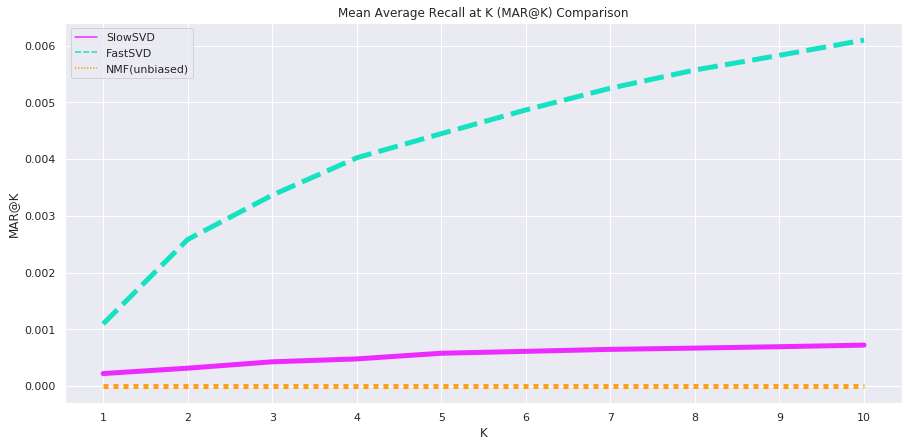

In [198]:
mark_scores = [slow_svd_mark, fast_svd_mark, nmf_mark]
index = range(1,10+1)
names = ['SlowSVD', 'FastSVD', 'NMF(unbiased)']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

### 5.3 Coverage

In [200]:
catalog = ratings.movieID.unique().tolist()
slowsvd_coverage = recmetrics.catalog_coverage(slowsvd_predictions, catalog, 100)
fastsvd_coverage = recmetrics.catalog_coverage(fastsvd_predictions, catalog, 100)
nmf_coverage = recmetrics.catalog_coverage(nmf_predictions, catalog, 100)

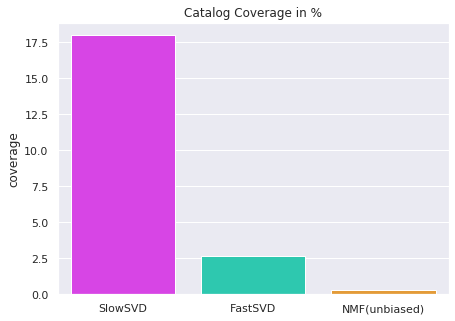

In [201]:
coverage_scores = [slowsvd_coverage, fastsvd_coverage, nmf_coverage]
model_names = ['SlowSVD', 'FastSVD', 'NMF(unbiased)']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)